# Preprocessing of sample KS414 and clustering analysis
In this notebook, I preprocessed the sample KS414 and saved a processed copy. This sample will be used for analyzing classifier predictions and for visualization purposes. Following the preprocessing, I performed a tumor clustering analysis. In this notebook I also generated panel A and B of **Figure 17**.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

#### I imported the sample KS414 I generated in the notebook `extracting_individual_samples_from_GBM.ipynb`

In [3]:
test = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/KS414_refined.h5ad')

In [4]:
test.var = (
    test.var
    .reset_index()                      
    .rename(columns={'index': 'ensemble_ids'})  
    .set_index('Gene')                  
)

test.var.index = test.var.index.astype(str)
test.var_names_make_unique(join="_")

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:767: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['marker-DsRed', 'marker-Cherry', 'marker-GFP', 'marker-Tomato', 'marker-cre']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


## Step 1: pre-processing

#### I normalized the data by row and applied a logarithmic transformation. Afterward, I identified the highly variable genes and scaled the data by column. These genes were then used for PCA computation. Additionally, I performed Leiden clustering, created a UMAP visualization, and saved the results.

**Note**: It is recommended to scale the data before conducting PCA. Initially, when I created this notebook, I was unaware of this practice. Although I've corrected this oversight here, the UMAP visualization in the report might look slightly different because I did not scale the data before performing PCA and the subsequent analysis in the earlier versions.d.

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_pca.py:374: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 50


2025-02-08 18:10:59.863366: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-08 18:11:01.503249: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


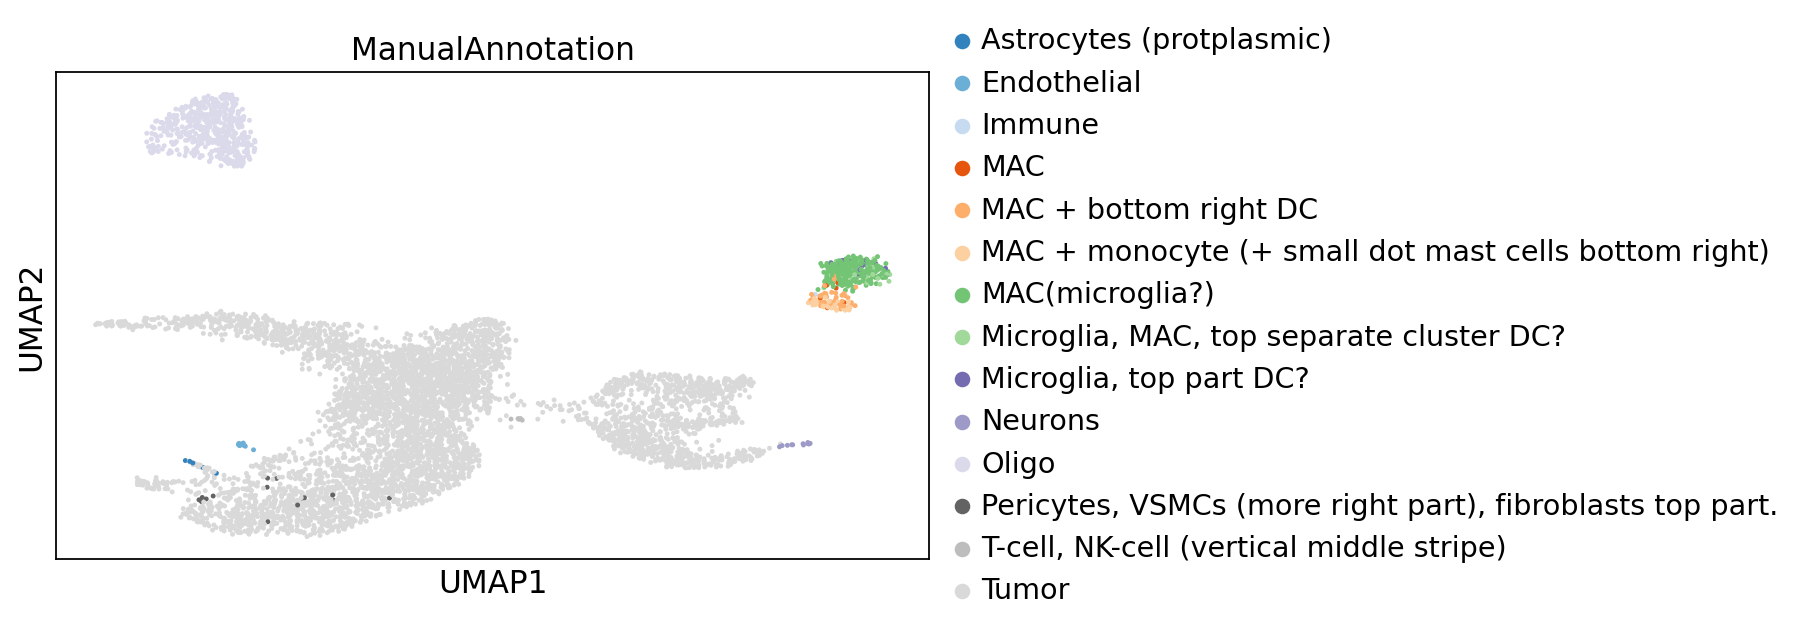

In [5]:
sc.pp.normalize_total(test, target_sum=1e4)
sc.pp.log1p(test)
sc.pp.highly_variable_genes(test, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(test)
sc.tl.pca(test, svd_solver='arpack', use_highly_variable = True)
sc.pp.neighbors(test, n_neighbors=25, n_pcs=50)
sc.tl.umap(test)
sc.pl.umap(test, color='ManualAnnotation', palette ='tab20c')

In [6]:
test.write_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/KS414_refined_with_umap.h5ad')

## Step 2: tumor KS414 clustering analysis

#### I selected the tumor cells and ran the Leiden clustering algorithm

In [7]:
tumor = sc.read_h5ad('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/final_useful_datasets/KS414_refined_with_umap.h5ad')

In [8]:
tumor = tumor[tumor.obs.ManualAnnotation == 'Tumor']

In [9]:
sc.tl.leiden(
    tumor,
    resolution=0.1,
    random_state=0,
    flavor="igraph",
    n_iterations=10,
    directed=False,
)

running Leiden clustering


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/tools/_leiden.py:199: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_added] = pd.Categorical(


    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


#### I visualized the clusters

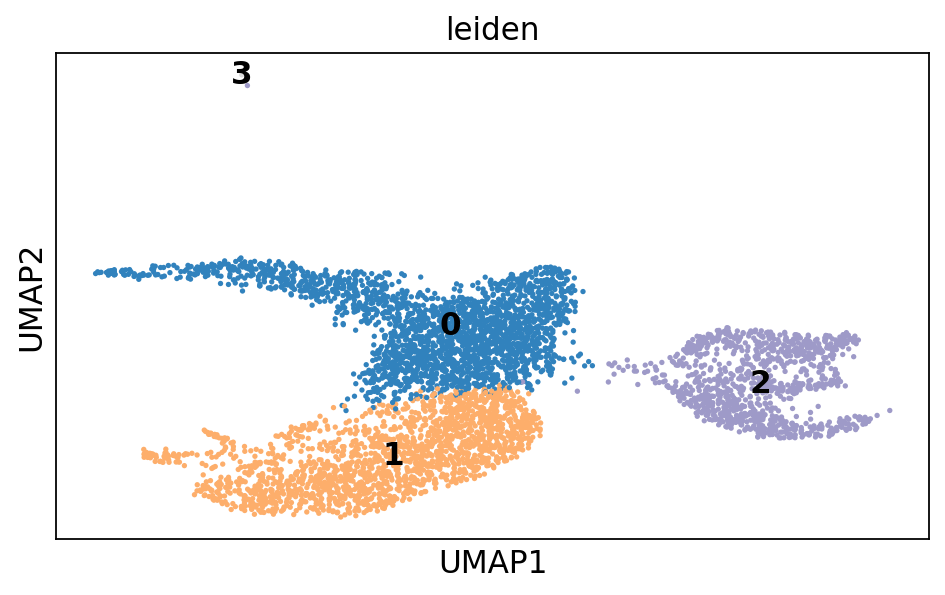

In [10]:
sc.pl.umap(tumor, color='leiden', palette ='tab20c', legend_loc = 'on data')

#### I eliminated the mithocondrial and ribosomal genes, as well as MALAT1.

In [11]:
ccGenesHuman = np.loadtxt('/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/models/ccGenesHuman.txt', dtype=str)
mask = ~tumor.var_names.isin(ccGenesHuman)
cc2 = ['CCND2', 'TFDP2']
tumor = tumor[:, ~np.isin(tumor.var_names, cc2)]

badGenes = [el for el in tumor.var_names 
            if el.startswith(('MT-', 'RP', 'TUB')) or el == 'MALAT1']

tumor = tumor[:, ~np.isin(tumor.var_names, badGenes)]

#### The Leiden algorithm has identified one cell as individual clusters. To prevent computational errors during marker analysis, I have removed these cells.

In [12]:
tumor = tumor[~tumor.obs['leiden'].isin(['3'])]

#### I ran a Differential Expression Analysis between clusters to identify the marker genes.

In [13]:
sc.tl.rank_genes_groups(tumor, "leiden", method="logreg")

ranking genes


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:06)


In [14]:
for group in tumor.uns['rank_genes_groups']['names'].dtype.names:
    genes = tumor.uns['rank_genes_groups']['names'][group][:25]
    print(f"Group {group}:")
    print(", ".join(genes))
    print("\n")

Group 0:
FGF12, POLR2F, TNR, TNS3, CA10, PCDH15, LHFPL3, CSMD1, DPP6, MAML2, DSCAM, SOX6, FERMT1, OPCML, LDLRAD3, IGSF9B, NXPH1, VIPR2, KAZN, PLPPR1, XYLT1, AL512308.1, GRID2, GLCCI1, SEMA5A


Group 1:
GFAP, NPSR1, GABRB1, GLIS3, ADGRV1, AC068587.4, IGFBP5, SLC4A4, ARHGEF4, AVIL, DGKG, HIF3A, CHL1, CLU, SHROOM3, TNIK, RFX4, EEPD1, PYGL, COL28A1, RGMA, AC091078.1, ZBTB7C, MMD2, WLS


Group 2:
DLX6-AS1, MYT1L, SRRM4, PLXNA4, CACNA2D3, RND3, MAML3, NEDD4L, CELF4, SORBS2, KALRN, TOX, ANO4, NRG1, DLX5, ERBB4, DOCK4, BCL11B, NRXN3, SPOCK1, ABTB2, FRMD4A, STMN2, ST18, AC099520.1




#### Finally, I plotted some marker genes on the UMAP already computed. This helped with the manual annotation of the clusters.

In [15]:
early_radial_glia = [
    "LIX1",
    "LEF1",
    "HEY1",
    "CRABP2",
    "AMBN"
]

astrocytes = [
    "SPARCL1",
    "NEAT1",
    "GLIS3",
    "TNC"
]

gIPC = [
    "EGFR",
    "KIRREL3",
    "DPF3",
    "SLIT1",
    "IRX1",
    "VIPR2"
]

OPC = [
    "PCDH15",
    "OPCML",
    "CSMD3",
    "CA10"
]

late_radial_glia = [
    "IQGAP2",
    "AKAP12",
    "EVA1C"
]

nIPC = [
    "SRRM4",
    "PLXNA2",
    "MYT1L",
    "RBFOX3",
]
pre_OPC =  [
    "ASCL1", 
    "DLL3"
    ]
pre_astrocytes = [
    "VAV3",
    "EGR1",
    "DPF3",
    "CSMD1"]

sub_nIPC = ["DLX5",
            "DLX6-AS1"]

In [16]:
sc.set_figure_params(facecolor="white", figsize=(6, 5))

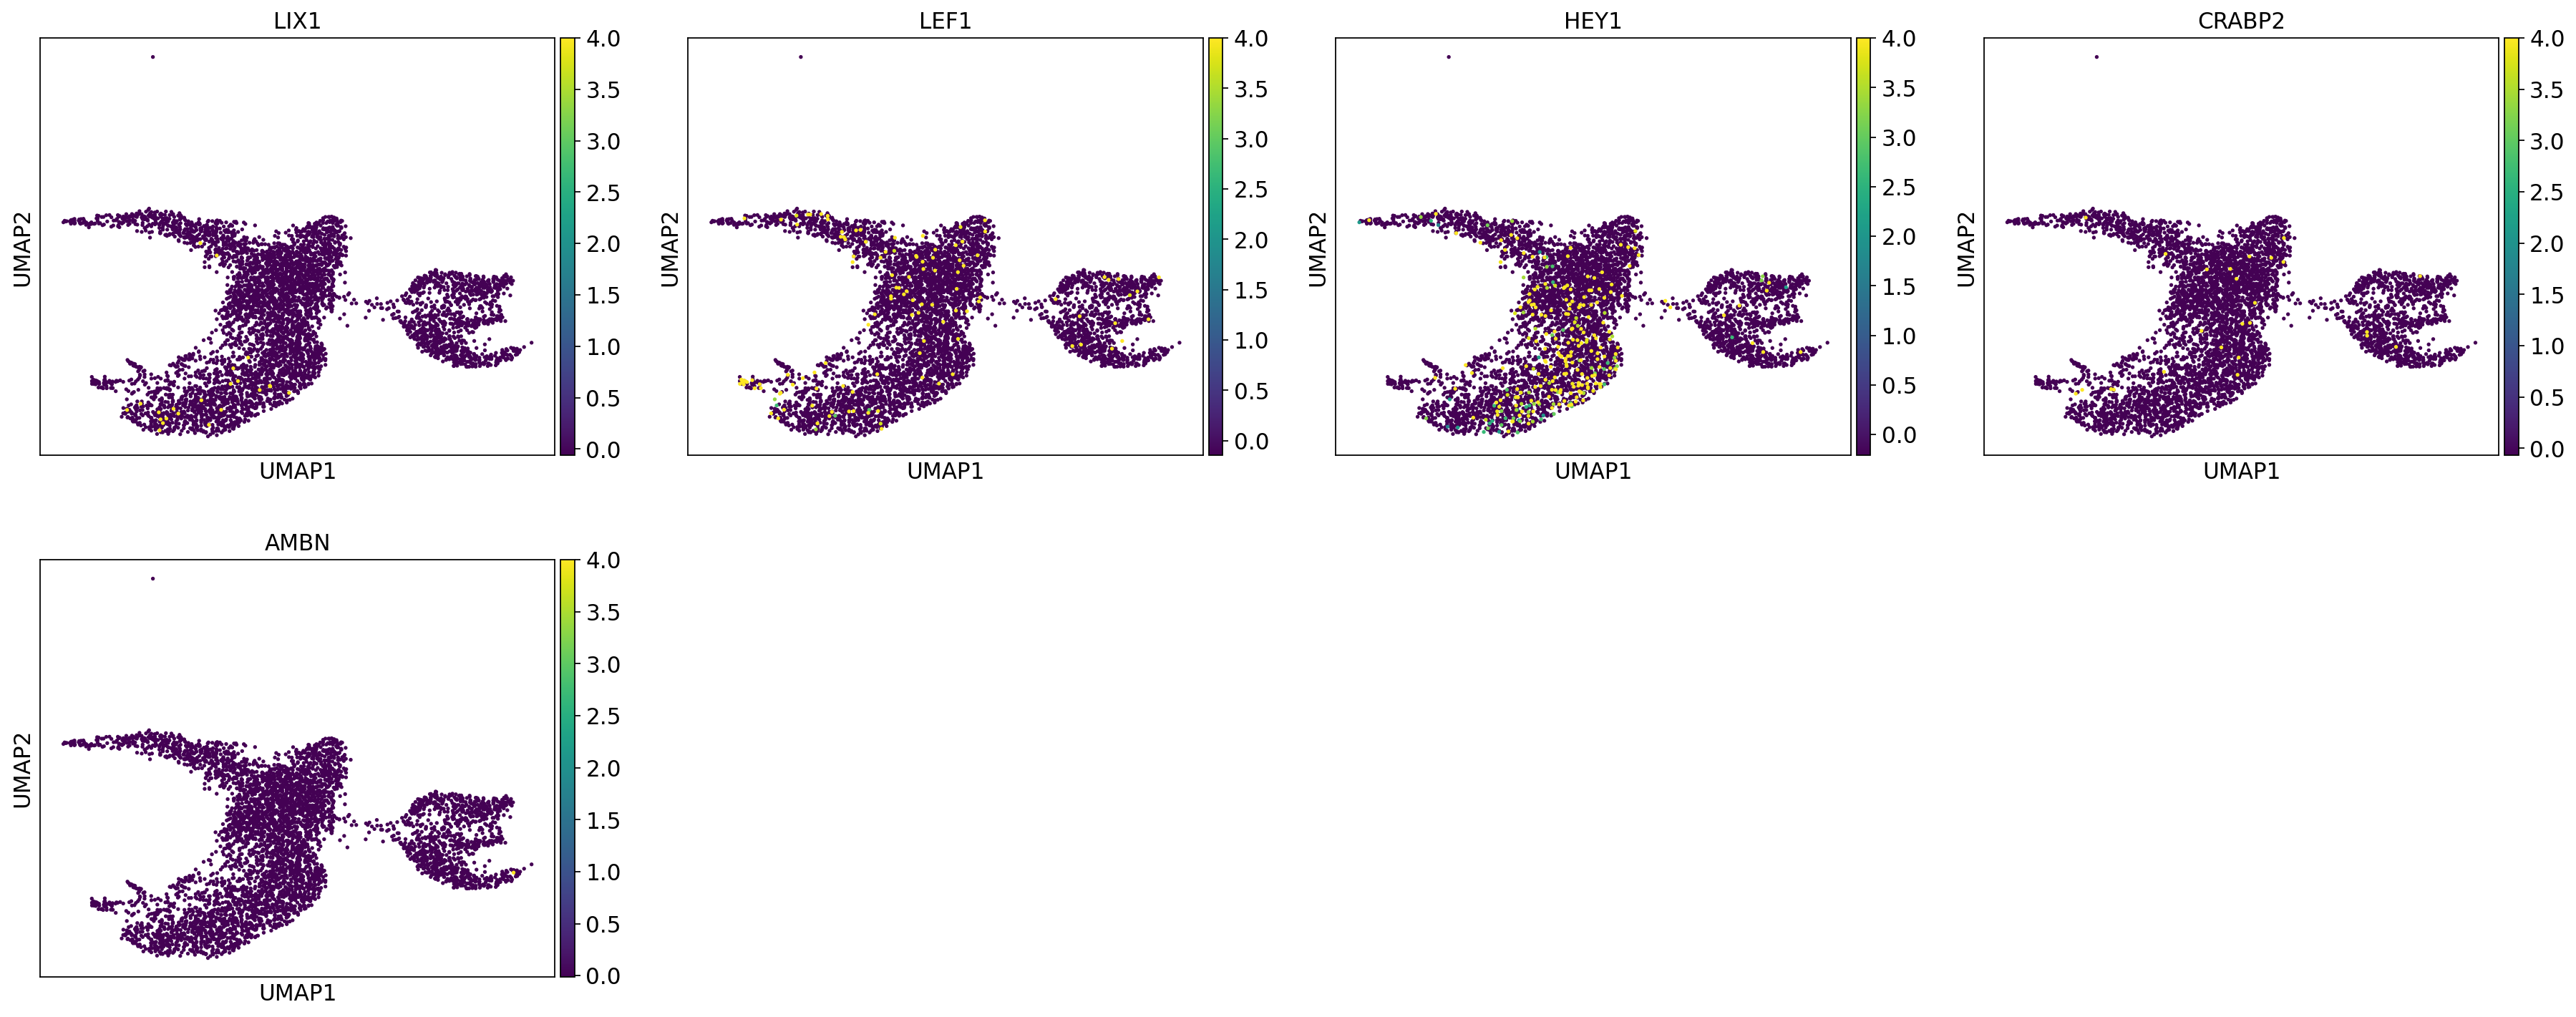

In [17]:
sc.pl.umap(tumor, color=early_radial_glia, palette = 'tab20', vmax=4)

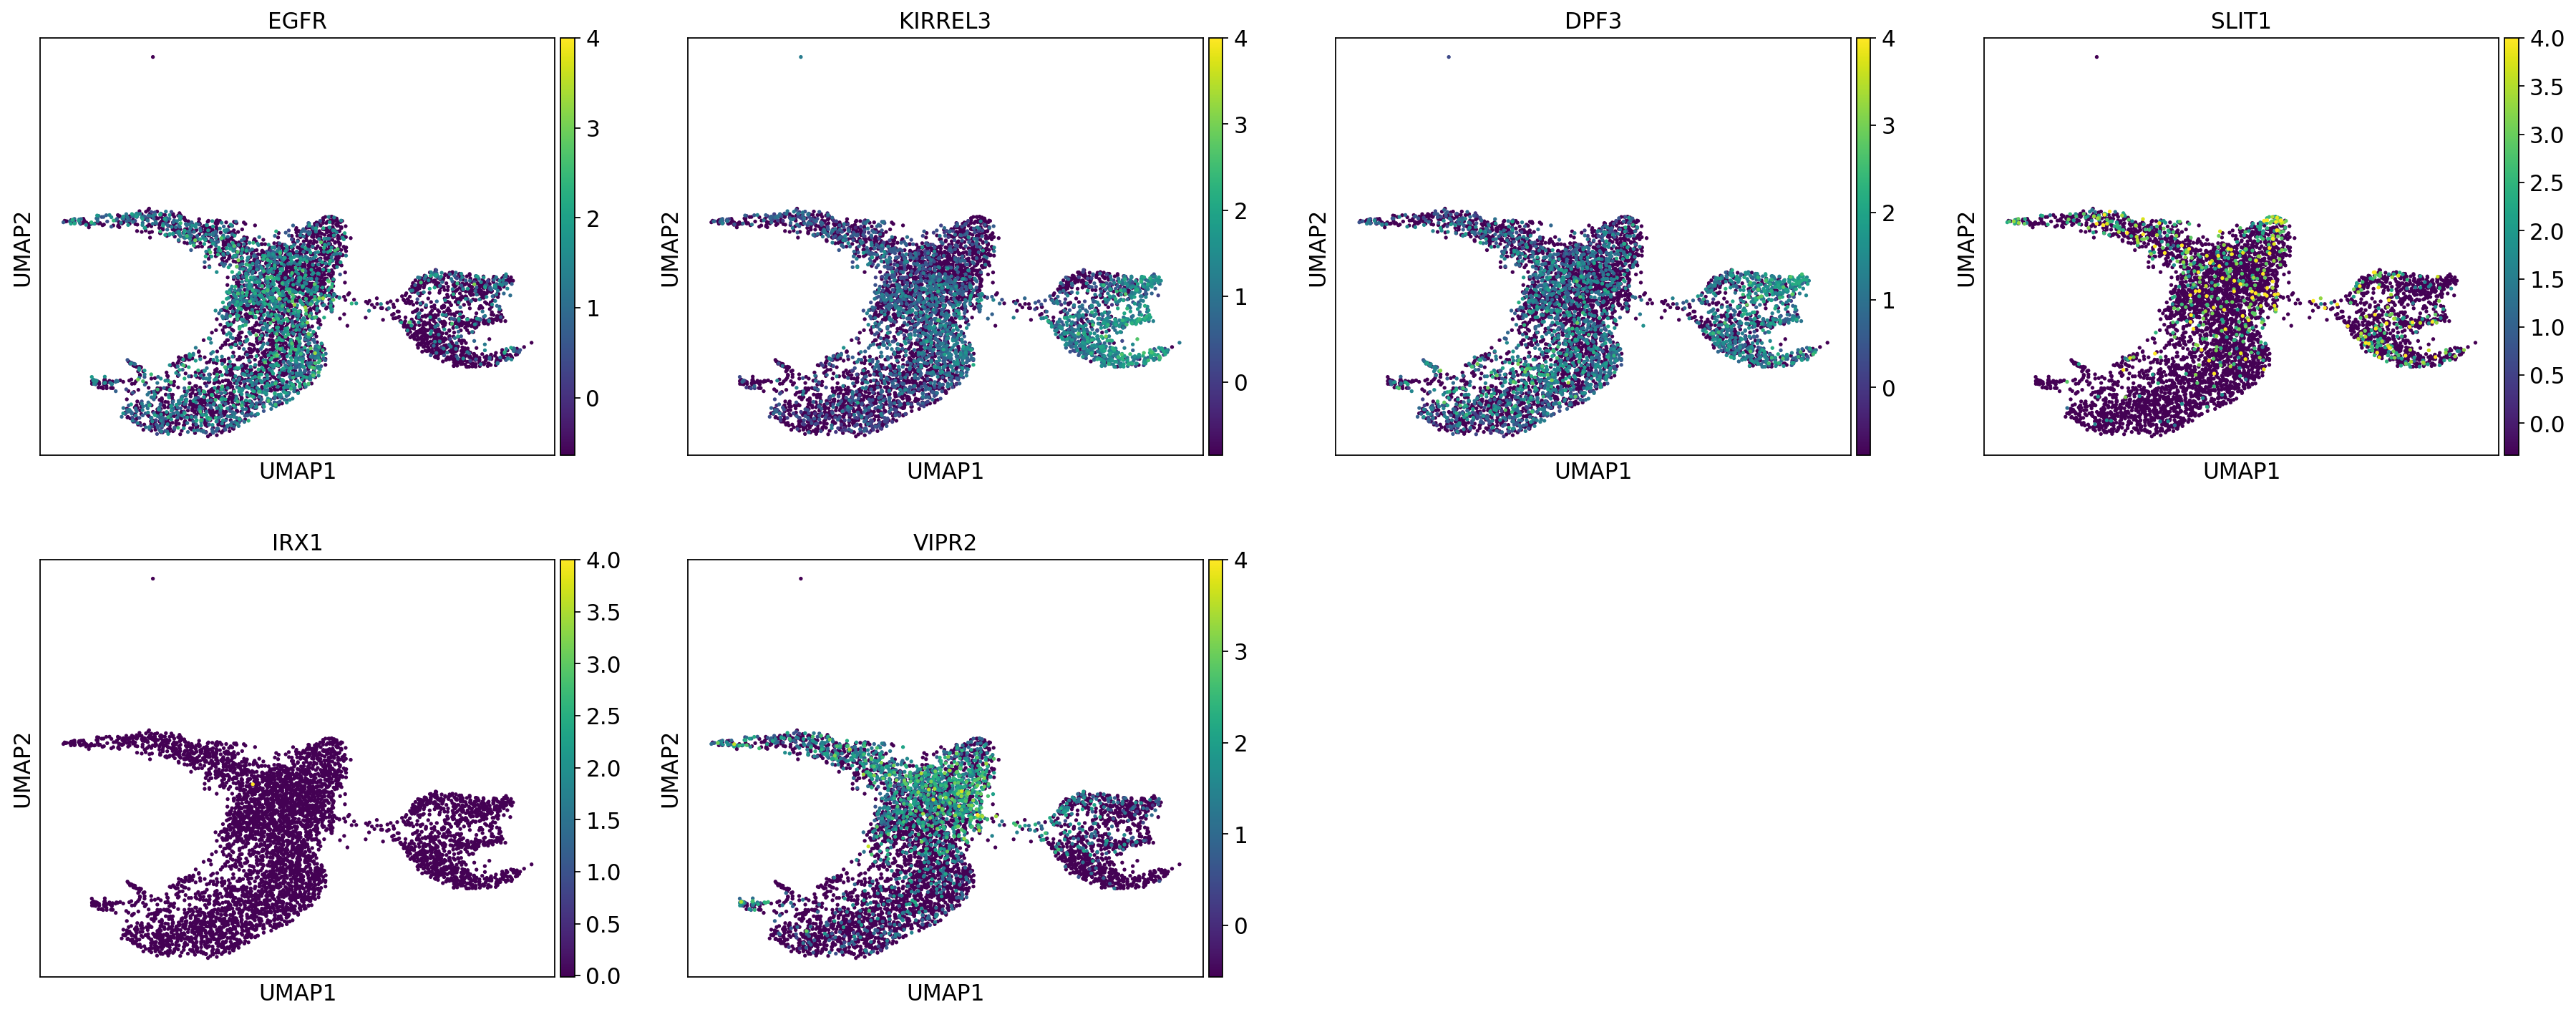

In [18]:
sc.pl.umap(tumor, color=gIPC, palette = 'tab20', vmax= 4)

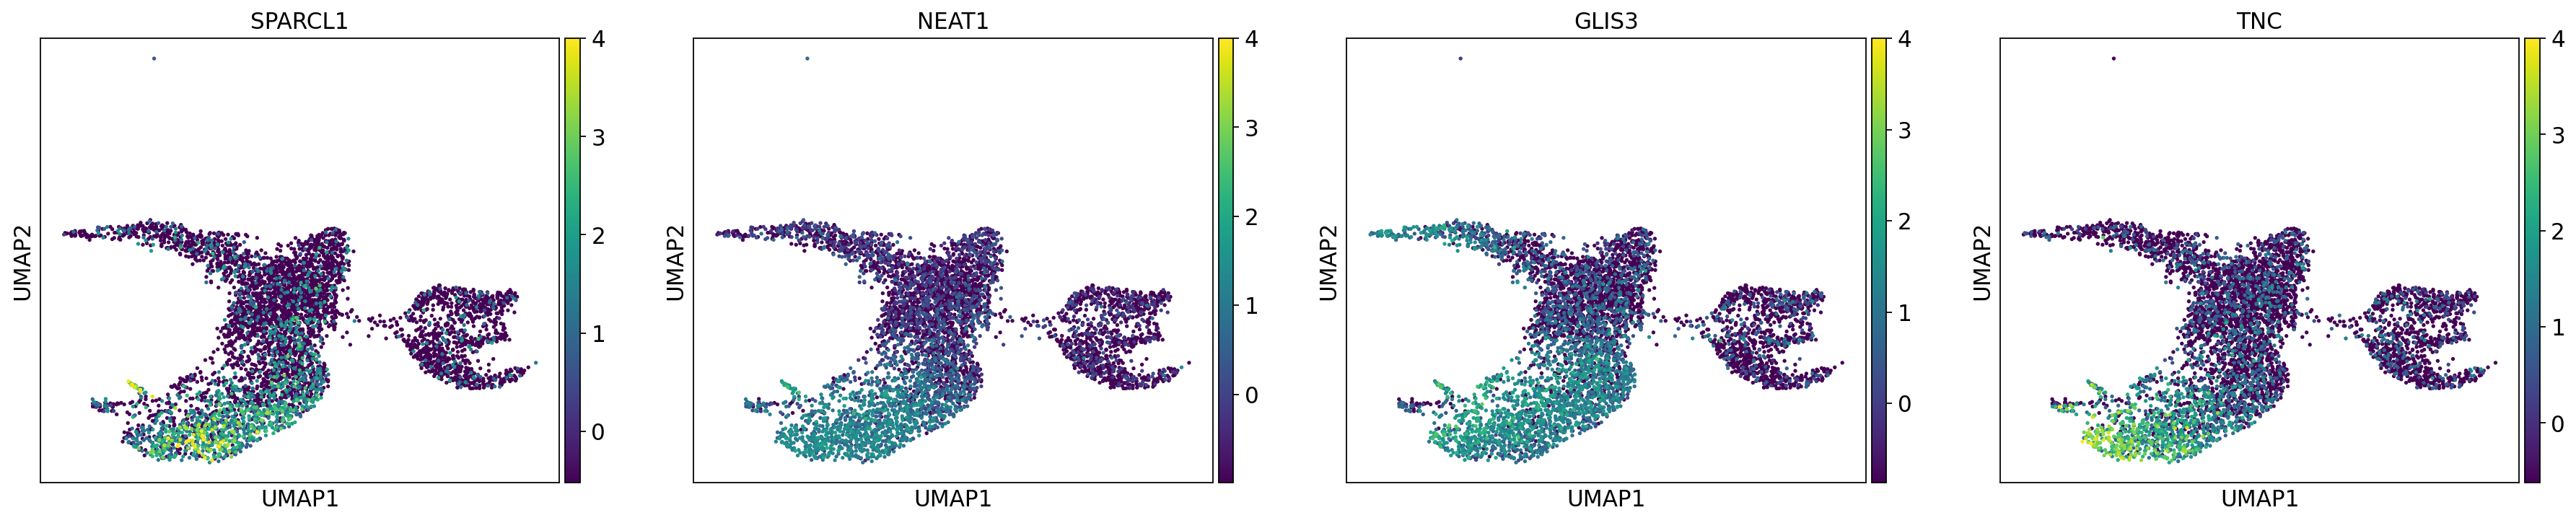

In [19]:
sc.pl.umap(tumor, color=astrocytes, palette = 'tab20', vmax= 4)

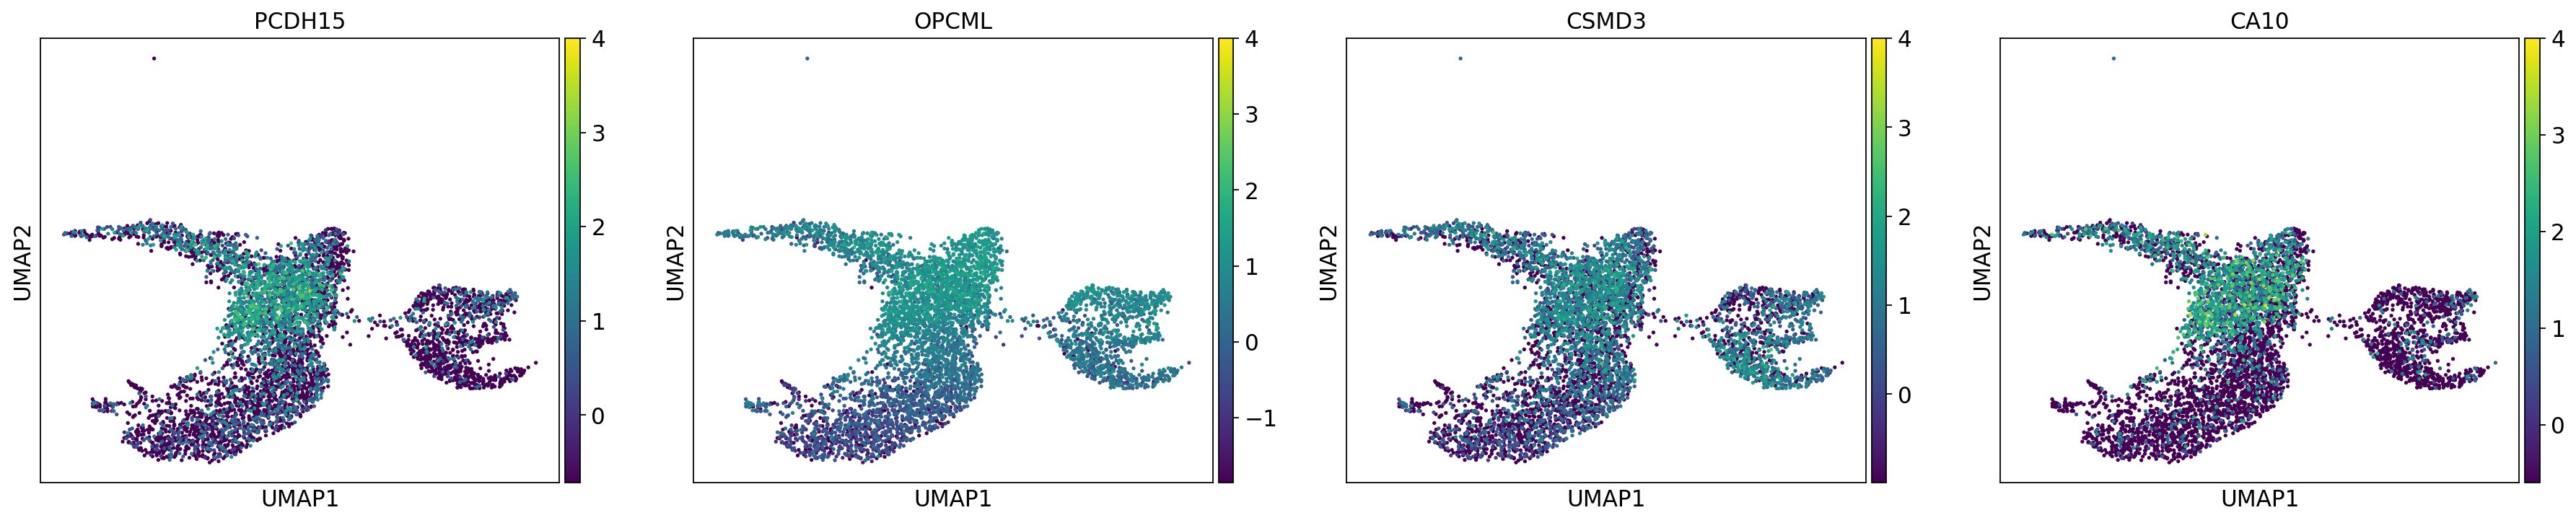

In [20]:
sc.pl.umap(tumor, color=OPC, palette = 'tab20', vmax= 4)

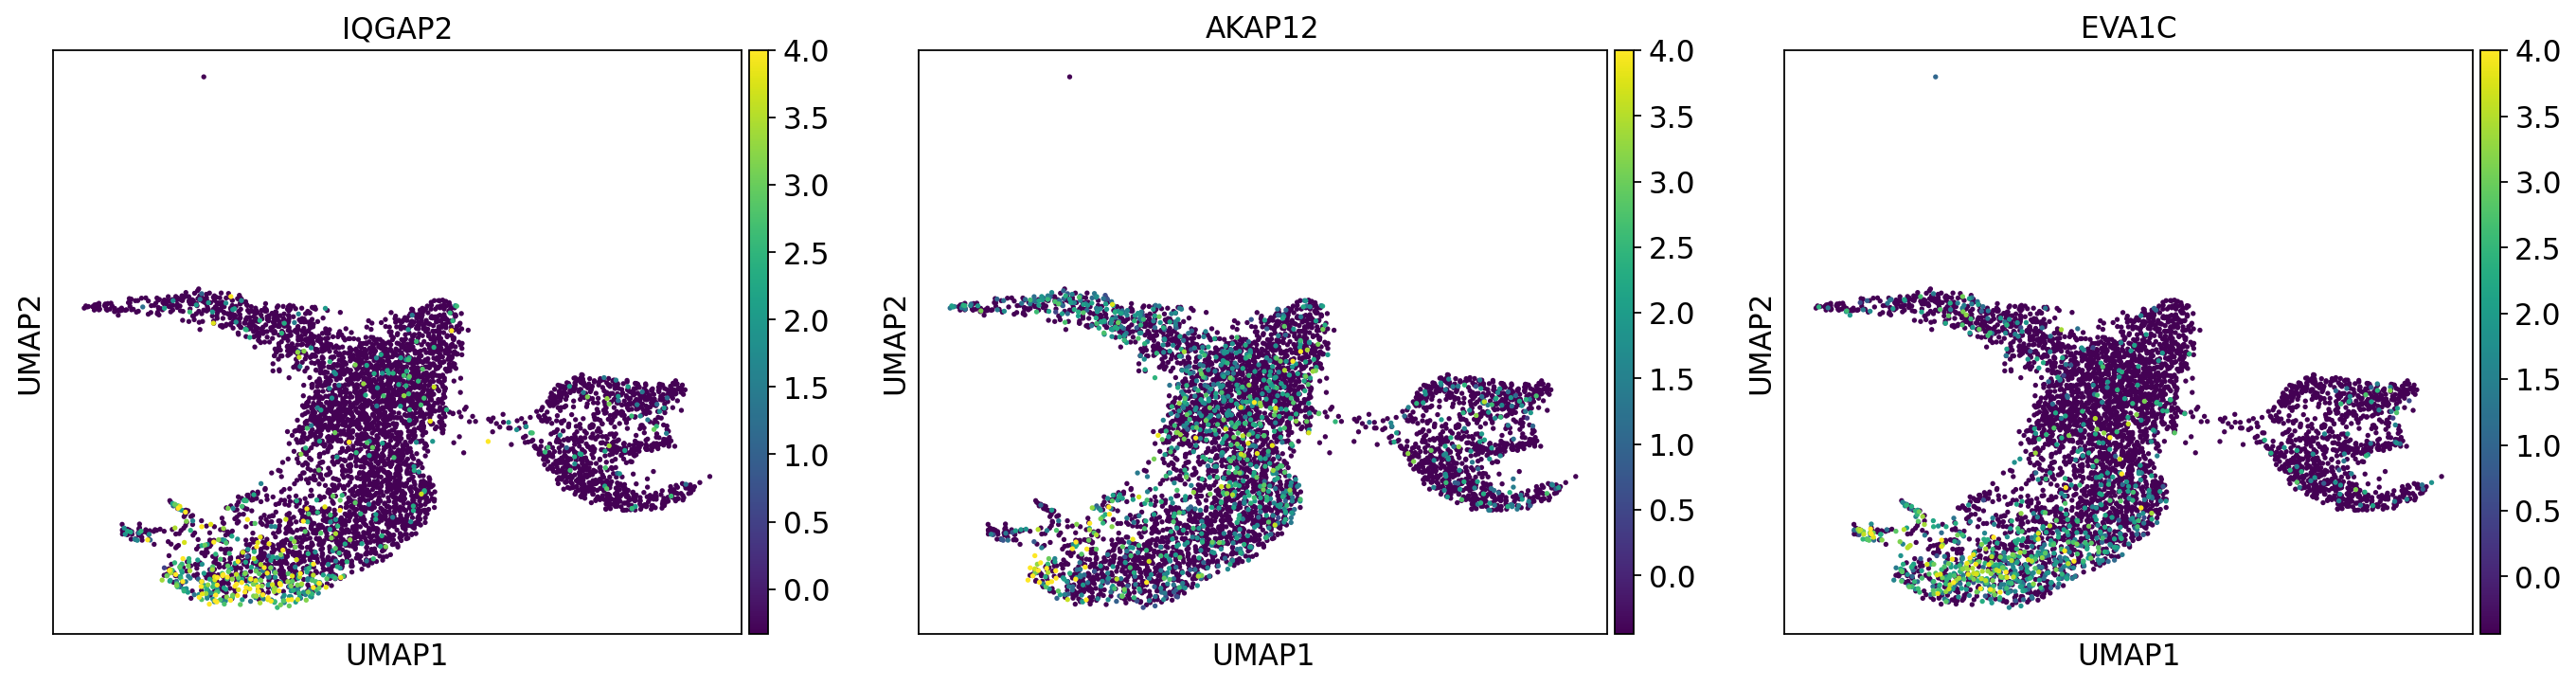

In [21]:
sc.pl.umap(tumor, color=late_radial_glia, palette = 'tab20', vmax= 4)

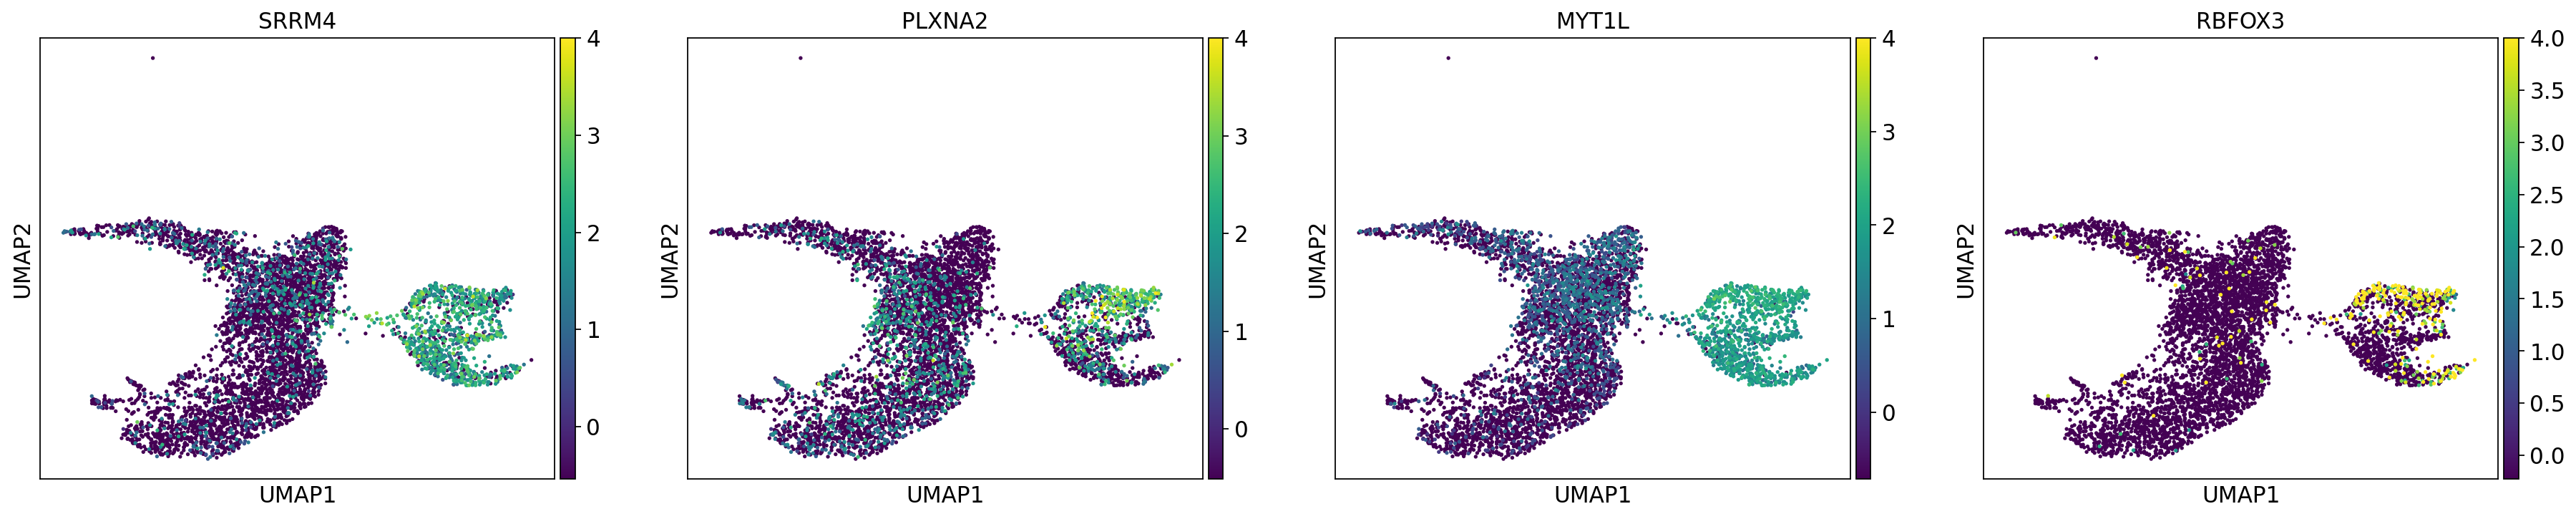

In [22]:
sc.pl.umap(tumor, color=nIPC, palette = 'tab20', vmax= 4)

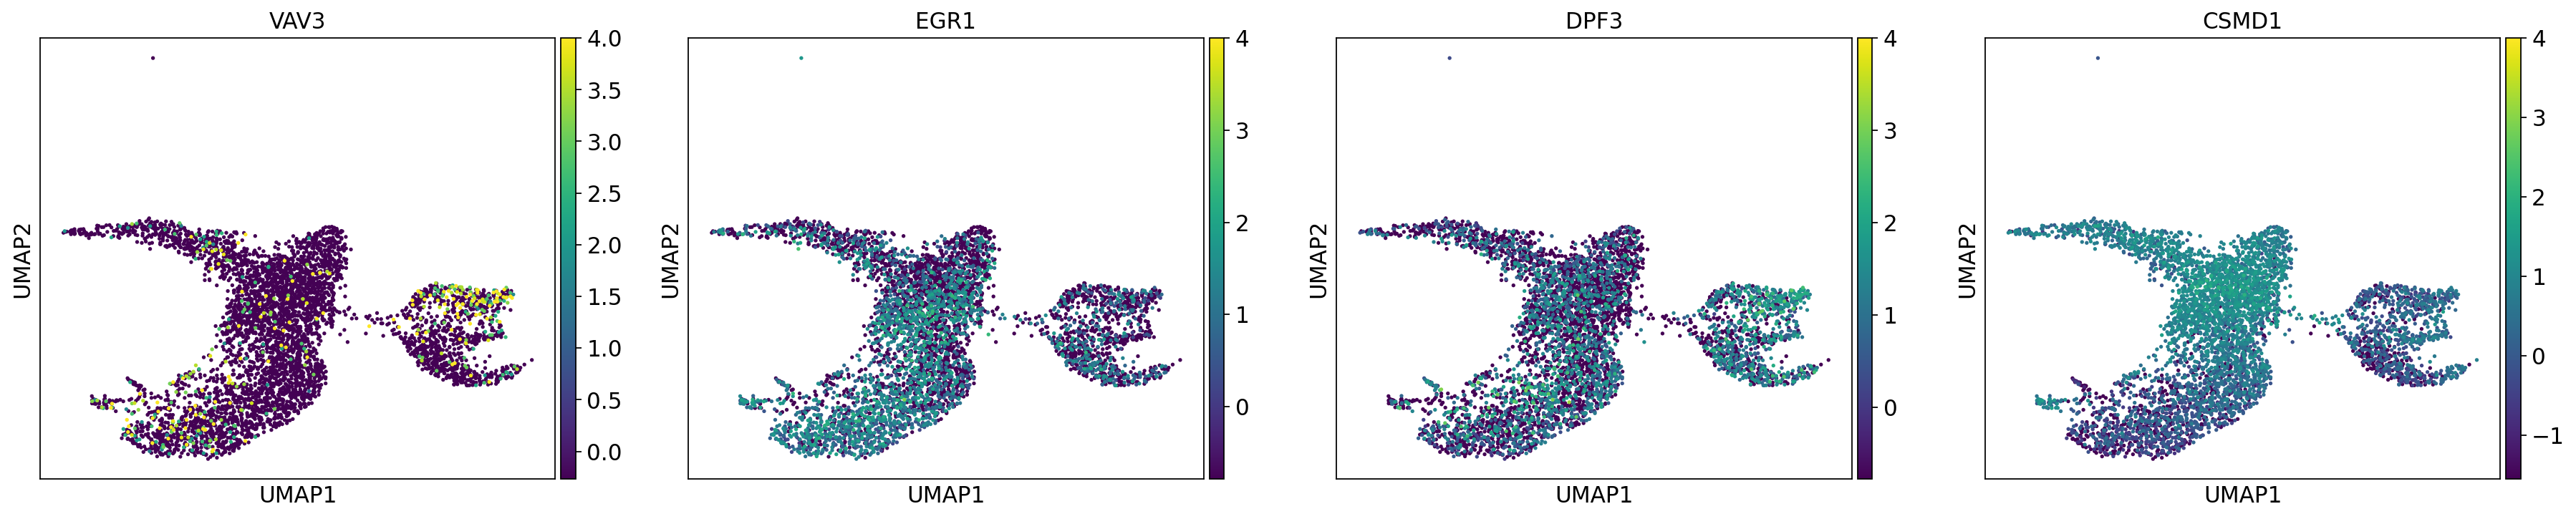

In [23]:
sc.pl.umap(tumor, color=pre_astrocytes, palette = 'tab20', vmax= 4)

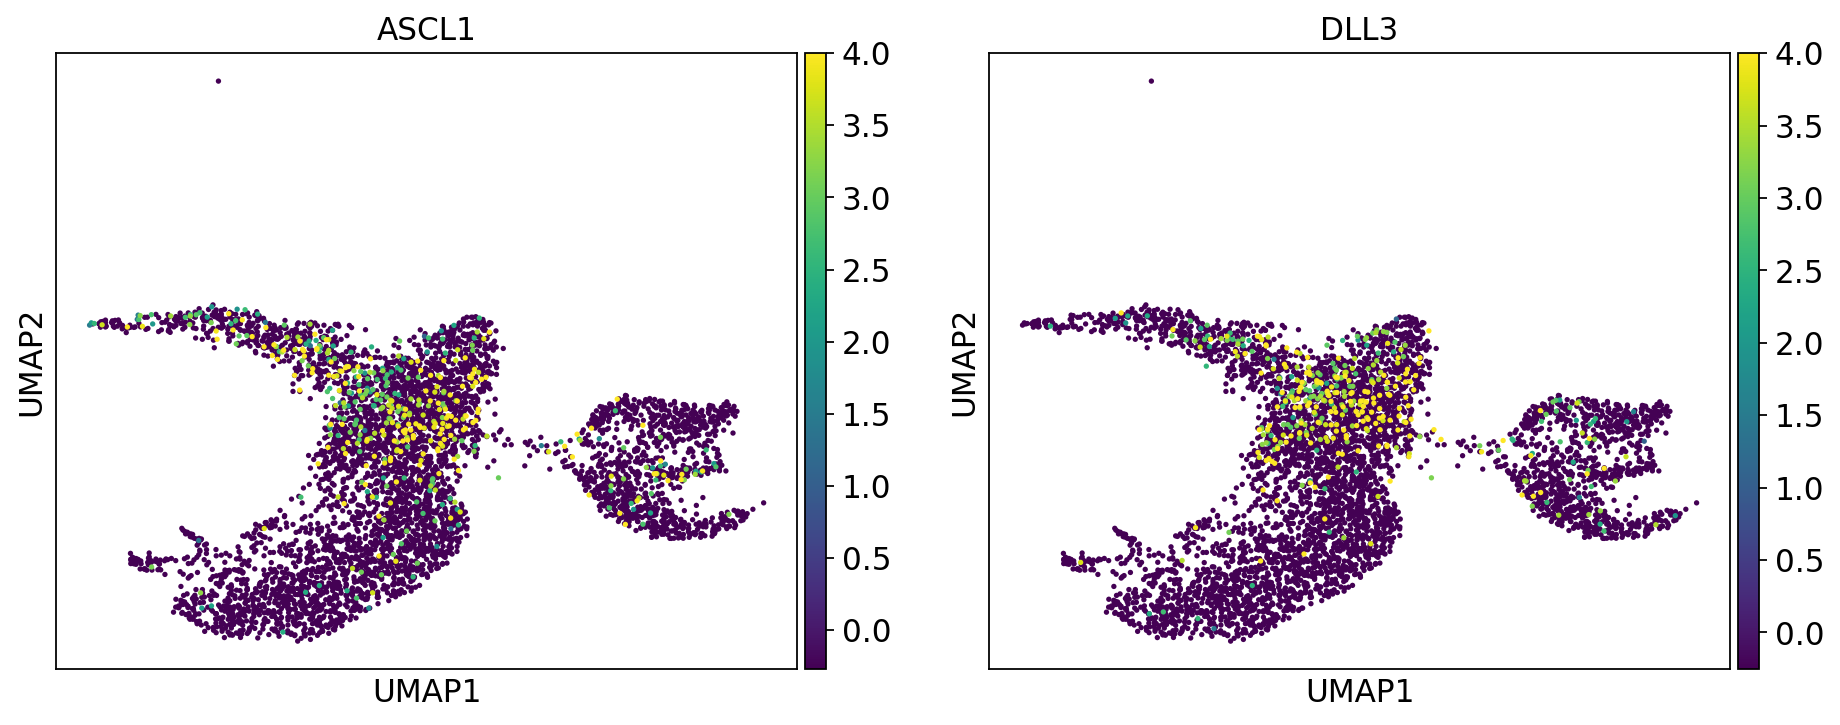

In [24]:
sc.pl.umap(tumor, color=pre_OPC, palette = 'tab20', vmax= 4)

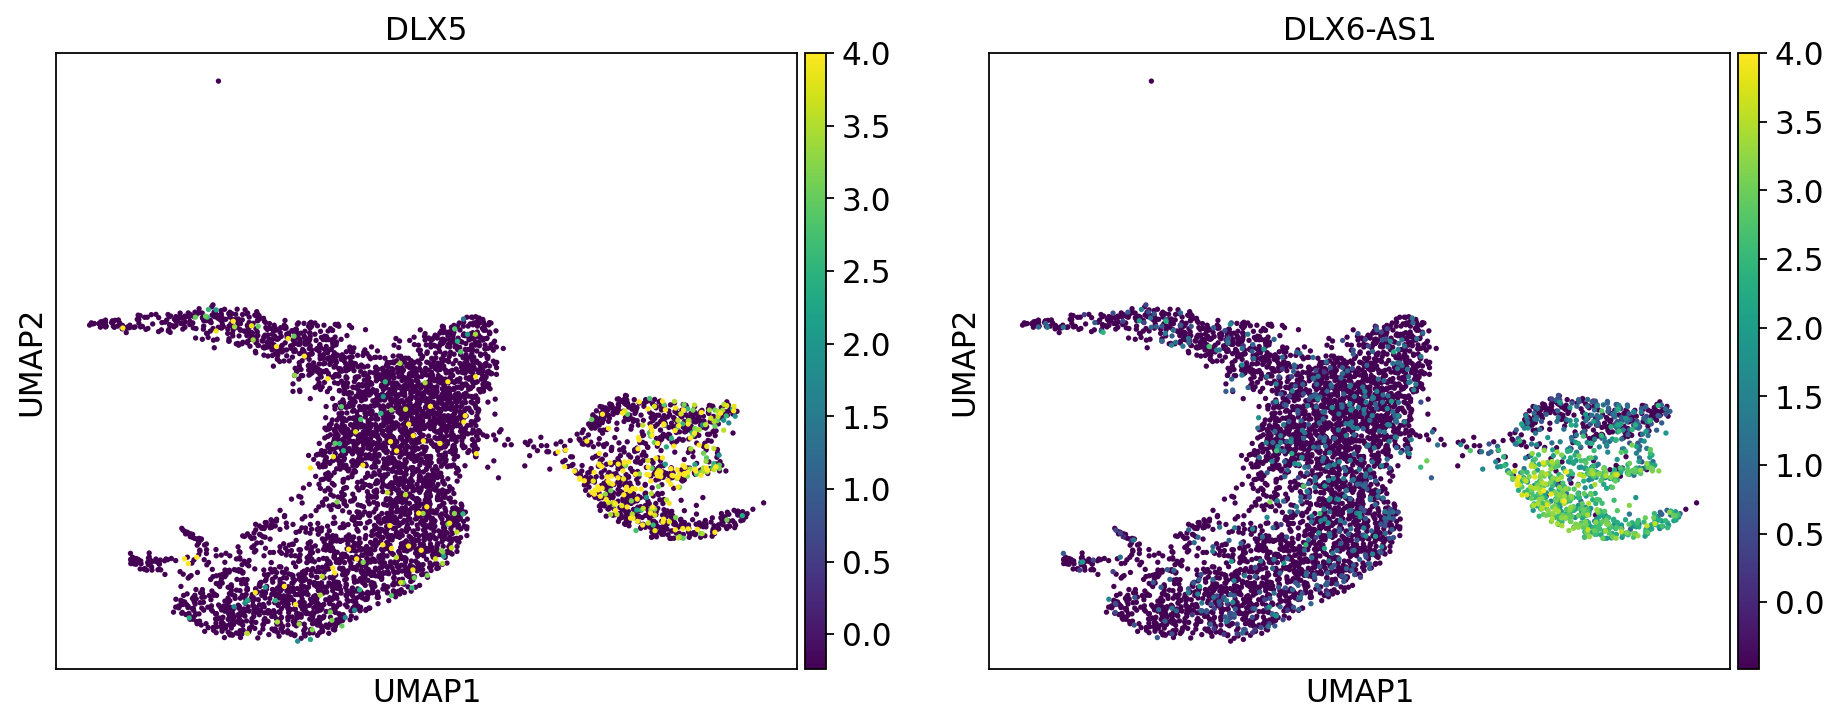

In [25]:
sc.pl.umap(tumor, color=sub_nIPC, palette = 'tab20',  vmax=4)

#### Based on my assessment of the 25 marker genes for each cluster and the visualization of known marker genes on the UMAP, I re-annotated the cells in the subsequent chunk.

In [26]:
cluster_to_annotation = {
    '0': 'OPC-like',
    '1': 'Astrocytic-like',
    '2': 'Unknown',
}

tumor.obs['ClusteringAnnotation'] = tumor.obs['leiden'].map(cluster_to_annotation)

## Figure 17

#### PANEL A

In [27]:
palette_A = ["#0cc0aa", "#b75970", "#7fdc64", "#2c647e", "#b1bf81", "#c5089e", "#8aafcf", "#513886", "#f4bb8f", "#b94414", "#9a82e0", "#1c5f1e", "#ee80fe", "#2cf52b", "#6118df", "#cace01", "#ea1349", "#f3c5fa", "#4b481f", "#fbbd13", "#208eb7", "#bce333", "#bc5857", "#2af385", "#eb1241", "#90d796", "#d148d3", "#26496d", "#f8cca6", "#7f73ed", "#6c8c60", "#e9c9fa", "#621da6", "#4bd6fd", "#1b511d", "#e1c637", "#ae896e", "#15974d", "#d6790b", "#604020", "#2af385", "#4bd6fd", "#d6790b", "#6c8c60", "#58b5e1"]

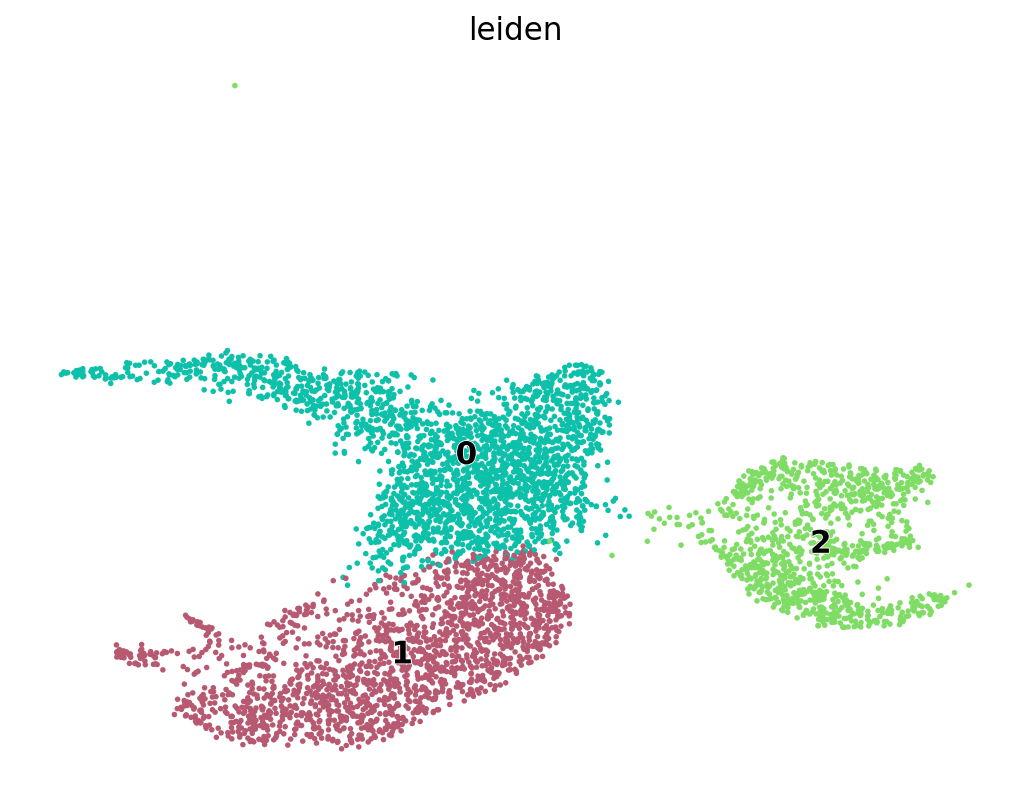

In [28]:
sc.set_figure_params(facecolor="white", figsize=(8, 6))

fig = sc.pl.embedding(
    tumor,
    basis='X_umap',
    color='leiden',
    palette=palette_A,
    size=25,
    legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=0.8,
    frameon=False,
    show=False,
    return_fig=True
)


# uncomment this to save high quality figure
# fig.savefig('fig_17_panel_A.png', dpi=600)

#### PANEL B

In [29]:
palette_B = [ "#f6248f","#0064e1","#94abe1", "#7d4400"]

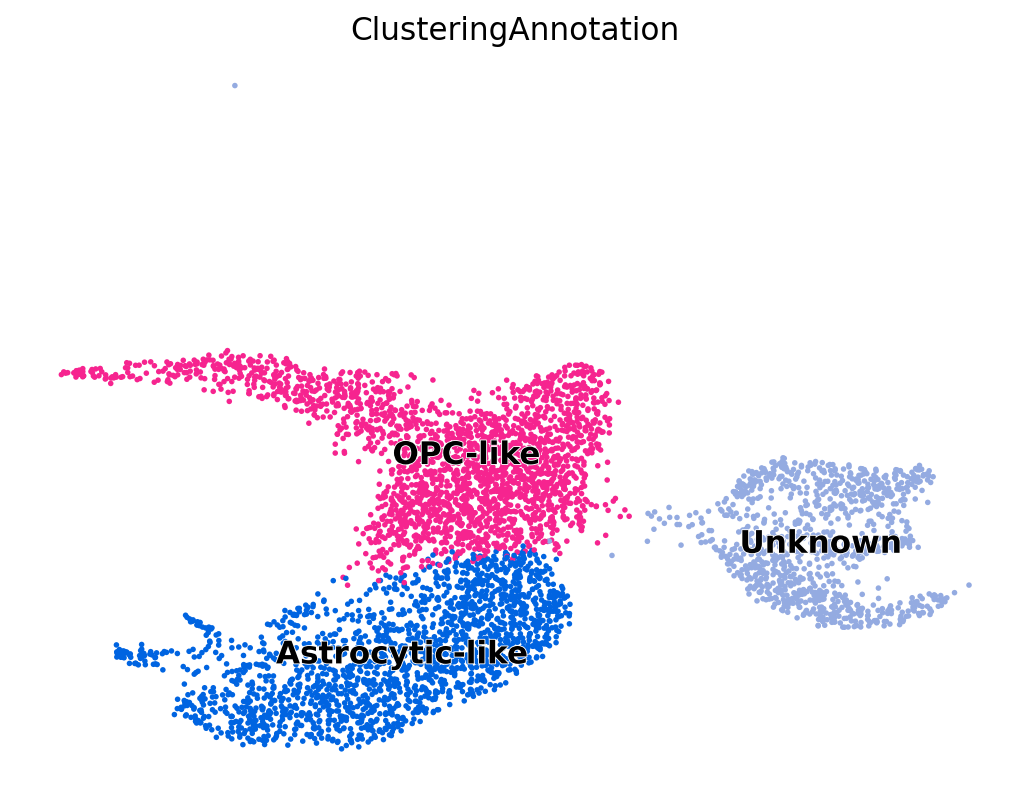

In [30]:
fig = sc.pl.embedding(
    tumor,
    basis='X_umap',
    color='ClusteringAnnotation',
    palette=palette_B,
    size=25,
    legend_loc='on data',
    legend_fontsize=14,
    legend_fontoutline=0.8,
    frameon=False,
    show=False,
    return_fig=True
)
# uncomment this to save high quality figure
# fig.savefig('fig_17_panel_B.png', dpi=600)